# PUI2017 HW4 Assignment 4
### sac820@nyu.edu

# Part 0: Setup

1. Import libraries
2. Set single significance threshold for entire exercise
3. Read in data

In [5]:
import pylab as pl
import pandas as pd
import numpy as np
import os
import scipy.stats
from getCitiBikeCSV import getCitiBikeCSV
from astral import Astral
import datetime
import geopandas as gpd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
#Set significance threshold for entire project
alpha = 0.05

<center>**The significance threshold is 0.05**<center>
<br>
$$\alpha = 0.05$$

#### Read in data for a cold month and a hot month and then clean up data

In [7]:
#Use January and July data in 2015
datestring_00 = '201501'
datestring_01 = '201508'

#Download data
getCitiBikeCSV(datestring_00)
getCitiBikeCSV(datestring_01)

#Open data in Python as dataframes
df_00 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring_00 + '-citibike-tripdata.csv')
df_01 = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring_01 + '-citibike-tripdata.csv')

#Turn starttimes into datetimes
df_00['starttime'] = pd.to_datetime(df_00['starttime'])
df_01['starttime'] = pd.to_datetime(df_01['starttime'])

#Combine dataframes
frames = [df_00, df_01]
citibikeData = pd.concat(frames)

('Downloading', '201501')
file in place, you can continue
('Downloading', '201508')
file in place, you can continue


In [8]:
citibikeData.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [9]:
citibikeData.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346,2015-01-01 00:01:00,1/1/2015 0:24,455,1 Ave & E 44 St,40.750020,-73.969053,265,Stanton St & Chrystie St,40.722293,-73.991475,18660,Subscriber,1960.0,2
1,363,2015-01-01 00:02:00,1/1/2015 0:08,434,9 Ave & W 18 St,40.743174,-74.003664,482,W 15 St & 7 Ave,40.739355,-73.999318,16085,Subscriber,1963.0,1
2,346,2015-01-01 00:04:00,1/1/2015 0:10,491,E 24 St & Park Ave S,40.740964,-73.986022,505,6 Ave & W 33 St,40.749013,-73.988484,20845,Subscriber,1974.0,1
3,182,2015-01-01 00:04:00,1/1/2015 0:07,384,Fulton St & Waverly Ave,40.683178,-73.965964,399,Lafayette Ave & St James Pl,40.688515,-73.964763,19610,Subscriber,1969.0,1
4,969,2015-01-01 00:05:00,1/1/2015 0:21,474,5 Ave & E 29 St,40.745168,-73.986831,432,E 7 St & Avenue A,40.726218,-73.983799,20197,Subscriber,1977.0,1


# Part 1: Trip Duration for Day vs. Night

### 0: State Null and Alternative Hypotheses

<center>**Null Hypothesis:** The average duration of a Citibike trip at night is the same as a trip during the day.<center>

<br>

$$H_0: P_0 - P_1 = 0$$
$$H_a: P_0 - P_1 \neq 0$$




### 1: Read in and clean data

We need to define what is day and what is night. We can use the Astral Python library to determine when sunset and sunrise are during these dates in New York City. From there, we can separate the data into day and night trips. From there we can calculate the average trip duration.





In [10]:
#Make a copy of the original data
durationData = citibikeData.copy()

#Drop unneeded variables
durationData.drop(['start station id', 'start station name', 'start station latitude', 
                                 'start station longitude', 'end station id', 'end station name',
                                 'end station latitude', 'end station longitude', 'bikeid','usertype', 
                                 'birth year', 'gender', 'stoptime'], axis=1, inplace=True)

In [11]:
durationData.head()

,tripduration,starttime
0,1346,2015-01-01 00:01:00
1,363,2015-01-01 00:02:00
2,346,2015-01-01 00:04:00
3,182,2015-01-01 00:04:00
4,969,2015-01-01 00:05:00


In [12]:
#Create a year/month/day so we can match it to new dataframe for sunrise and sunset
durationData['date'] = [d.date() for d in durationData['starttime']]
durationData['starttime'] = [d.time() for d in durationData['starttime']]

durationData.head()

,tripduration,starttime,date
0,1346,00:01:00,2015-01-01
1,363,00:02:00,2015-01-01
2,346,00:04:00,2015-01-01
3,182,00:04:00,2015-01-01
4,969,00:05:00,2015-01-01


**Calculating sunrise and sunset given location and date:** Originally, we were going to use the Python Astral library. However, it kept having strange problems that were not easy to debug. (It kept insisting that the sun doesn't set in NYC.) So, we looked at the Astral documentation and learned that they actually used a spreadsheet with formulas from NOAA. So we downloaded this [spreadsheet](https://www.esrl.noaa.gov/gmd/grad/solcalc/calcdetails.html) and put in the correct latitude and longitude for NYC (40.7128, -74.006), timezone (UTC-5), and the correct date (January and August 2015) to obtain the sunrise and sunset times in NYC. We then copied these values to a new CSV and imported those. This is perhaps not the most automated or Pythonic way of doing this, but we had time constraints. If we had time, we would have looked at the formulas inside of the spreadsheet and made functions based off of that. 


In [13]:
sunriseSunset = pd.read_csv('nyc_sunrise_sunset.csv', parse_dates=True)
sunriseSunset['date'] = pd.to_datetime(sunriseSunset['date'])
sunriseSunset.head()

,date,sunrise,sunset
0,2015-01-01,7:20:08,16:39:28
1,2015-01-02,7:20:12,16:40:19
2,2015-01-03,7:20:14,16:41:12
3,2015-01-04,7:20:14,16:42:06
4,2015-01-05,7:20:12,16:43:02


**Mapping the new sunrise and sunset times to the dates:** We created dictionaries from the new Pandas dataframe and mapped them to the original dataframe. Mapping allows us to have multiple values for one key. That is, there are multiple observations from the original dataframe that happen on the same date and that will have the same sunset and sunrise times.

In [14]:
sunrise_to_date = sunriseSunset.set_index('date').to_dict()['sunrise']
sunset_to_date = sunriseSunset.set_index('date').to_dict()['sunset']

durationData['sunrise'] = durationData['date'].map(sunrise_to_date)
durationData['sunset'] = durationData['date'].map(sunset_to_date)

durationData.head()

,tripduration,starttime,date,sunrise,sunset
0,1346,00:01:00,2015-01-01,7:20:08,16:39:28
1,363,00:02:00,2015-01-01,7:20:08,16:39:28
2,346,00:04:00,2015-01-01,7:20:08,16:39:28
3,182,00:04:00,2015-01-01,7:20:08,16:39:28
4,969,00:05:00,2015-01-01,7:20:08,16:39:28


**Creating datetime values:** To make comparison of times easier, we made sure that the sunrise, sunset, and start time values were all date times with the same date.

In [15]:
durationData['sunrise'] = durationData['date'].astype(str) + ' ' + durationData['sunrise'].astype(str)
durationData['sunset'] = durationData['date'].astype(str) + ' ' + durationData['sunset'].astype(str)
durationData['starttime'] = durationData['date'].astype(str) + ' ' + durationData['starttime'].astype(str)

durationData['sunrise'] = pd.to_datetime(durationData['sunrise'])
durationData['sunset'] = pd.to_datetime(durationData['sunset'])
durationData['starttime'] = pd.to_datetime(durationData['starttime'])

durationData.head()

,tripduration,starttime,date,sunrise,sunset
0,1346,2015-01-01 00:01:00,2015-01-01,2015-01-01 07:20:08,2015-01-01 16:39:28
1,363,2015-01-01 00:02:00,2015-01-01,2015-01-01 07:20:08,2015-01-01 16:39:28
2,346,2015-01-01 00:04:00,2015-01-01,2015-01-01 07:20:08,2015-01-01 16:39:28
3,182,2015-01-01 00:04:00,2015-01-01,2015-01-01 07:20:08,2015-01-01 16:39:28
4,969,2015-01-01 00:05:00,2015-01-01,2015-01-01 07:20:08,2015-01-01 16:39:28


**Calculating if the trip is night or day:** We had some trouble using iterrows to assign new values into a dataframe column so we created a list which we would attach to the dataframe as a new column.

In [16]:
dayORnight = []

for index, row in durationData.iterrows():
    if (row['starttime'] > row['sunrise'] and row['starttime'] < row['sunset']): 
        dayORnight.append('day')
    else: 
        dayORnight.append('night')

In [17]:
lightORdark = pd.Series(dayORnight)
durationData['dayORnight'] = lightORdark.values
durationData.head()

,tripduration,starttime,date,sunrise,sunset,dayORnight
0,1346,2015-01-01 00:01:00,2015-01-01,2015-01-01 07:20:08,2015-01-01 16:39:28,night
1,363,2015-01-01 00:02:00,2015-01-01,2015-01-01 07:20:08,2015-01-01 16:39:28,night
2,346,2015-01-01 00:04:00,2015-01-01,2015-01-01 07:20:08,2015-01-01 16:39:28,night
3,182,2015-01-01 00:04:00,2015-01-01,2015-01-01 07:20:08,2015-01-01 16:39:28,night
4,969,2015-01-01 00:05:00,2015-01-01,2015-01-01 07:20:08,2015-01-01 16:39:28,night


**Calculate means and sample sizes for later tests:** We calculated the mean trip duration time of trips taken at night and trips taken during the day. We also calculated how many trips happened at night and how many during the day. There is a massive disparity between how many trips happen during the night versus the day.

In [107]:
nightData = durationData[durationData['dayORnight'] == 'night']
nightMean = mean(nightData['tripduration'])
nightSize = nightData.count(axis=0, numeric_only=True).values[0]


dayData = durationData[durationData['dayORnight'] == 'day']
dayMean = mean(dayData['tripduration'])
daySize = dayData.count(axis=0, numeric_only=True).values[0]

In [108]:
print(nightMean)
print(dayMean)

print(nightSize)
print(daySize)

908.247255143
961.182096841
401387
1063209


### 2: Kolmogorov-Smirnov Test

**Null hypothesis for Kolmogorov Smirnoff test:** 

$H_0:$ the samples of the trip durations at night and the trip durations during the day come from the same parent distribution.

<center>**Null hypothesis is rejected if:**<center>
<br>
$$D_{(n_1,n_2)} > c(\alpha) \sqrt{\dfrac{(n_1 + n_2)}{n_1n_2}}$$

Where $c(\alpha$) is the inverse of the KS distribution. You do not have to know how to get that because there are tables that list critical values.

This result depends in your choice of binning though, and thus the results you get by hand may not be exactly the same as the one the KS returns. Either way: this is how you would calculate the KS statistics by hand.

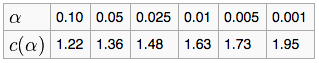

In [20]:
from IPython.display import Image
Image(filename="ks2sample_table.png")

**Plotting a histogram and CDF:** By plotting a histogram and then the cumulative distribution function, that will help set us up for the Kolmogorov-Smirnov test, as that test looks at the distance between the two CDFs.

In [109]:
print(nightData.tripduration.describe())
print(dayData.tripduration.describe())

count    4.013870e+05
mean     9.082473e+02
std      9.239682e+03
min      6.000000e+01
25%      3.830000e+02
50%      6.160000e+02
75%      1.012000e+03
max      2.712082e+06
Name: tripduration, dtype: float64
count    1.063209e+06
mean     9.611821e+02
std      5.987176e+03
min      6.000000e+01
25%      3.990000e+02
50%      6.440000e+02
75%      1.091000e+03
max      2.842280e+06
Name: tripduration, dtype: float64


It seems that there are some extreme duration times. I am not sure where they came from but let us drop any trip durations longer than the 75th percentile. 

In [110]:
nightData = nightData[nightData.tripduration < 1500]
dayData = dayData[dayData.tripduration < 1500]

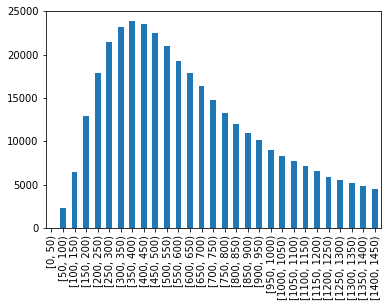

In [112]:
step = 50
bin_range = np.arange(0, nightData.tripduration.max(), step)
out, bins  = pd.cut(nightData.tripduration, bins=bin_range, include_lowest=True, right=False, retbins=True)
out.value_counts(sort=False).plot.bar()

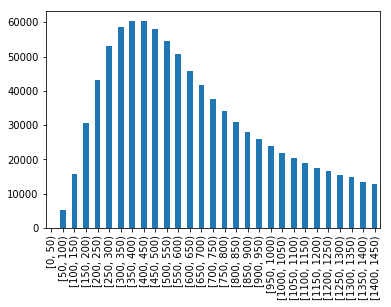

In [113]:
step = 50
bin_range = np.arange(0, dayData.tripduration.max(), step)
out, bins  = pd.cut(dayData.tripduration, bins=bin_range, include_lowest=True, right=False, retbins=True)
out.value_counts(sort=False).plot.bar()

**We want to make a cumulative distribution function of each to compare the difference between the two**

$$F_{x_0}(x) = P(x<x_0)$$

              count_nonzero
tripduration               
(0, 50]                 NaN
(50, 100]          0.000528
(100, 150]         0.001435
(150, 200]         0.004461
(200, 250]         0.007430
(250, 300]         0.009532
(300, 350]         0.010455
(350, 400]         0.011415
(400, 450]         0.011833
(450, 500]         0.011542
(500, 550]         0.010669
(550, 600]         0.009661
(600, 650]         0.009548
(650, 700]         0.009810
(700, 750]         0.010176
(750, 800]         0.010143
(800, 850]         0.010085
(850, 900]         0.010077
(900, 950]         0.010521
(950, 1000]        0.009644
(1000, 1050]       0.009203
(1050, 1100]       0.008678
(1100, 1150]       0.008056
(1150, 1200]       0.007137
(1200, 1250]       0.005704
(1250, 1300]       0.004297
(1300, 1350]       0.002878
(1350, 1400]       0.001672
(1400, 1450]       0.000000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


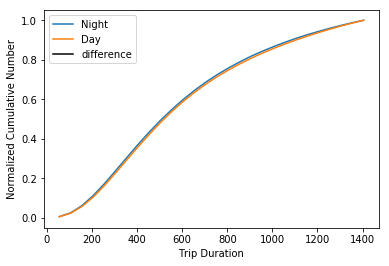

In [117]:
csNight=nightData.tripduration.groupby(pd.cut(nightData.tripduration, bins)).agg([count_nonzero]).cumsum()
csDay=dayData.tripduration.groupby(pd.cut(dayData.tripduration, bins)).agg([count_nonzero]).cumsum()

print (np.abs(csNight / csNight.max()-csDay / csDay.max()))

pl.plot(bins[:-1] + 5, csNight / csNight.max(), label = "Night")
pl.plot(bins[:-1] + 5, csDay / csDay.max(), label = "Day")
pl.plot(bins[:-1] + 5, (np.sqrt(csDay / csDay.max() - csNight / csNight.max()))**2, 'k-',
        label = "difference")
pl.xlabel("Trip Duration")
pl.ylabel("Normalized Cumulative Number")
pl.legend();

**Calculating the KS statistic that we compare our statistic to:**

In [118]:
daySize = dayData.count(axis=0, numeric_only=True).values[0]
nightSize = nightData.count(axis=0, numeric_only=True).values[0]

ks_statistic = 1.36 * sqrt((nightSize + daySize) / (nightSize * daySize))
print(ks_statistic)

0.0


In order to reject the null hypothesis, we need a KS statistic that is higher than the above printed value.

**Performing the KS test:**

In [102]:
ks = scipy.stats.ks_2samp(nightData.tripduration, dayData.tripduration)
print(ks)

Ks_2sampResult(statistic=0.025341326250195251, pvalue=2.5468964783149539e-161)


**Explaining the results:** The results return the KS statistic and the two-tailed p-value. Our statistic is higher than the 0.0 we received above but by only a tiny amount. And our p-value is well above 0.05. This means that we cannot reject the null. In this case, that means the two distributions - the trip durations at night and those during the day - come from the same distribution and do not represent two distinct distributions.


**Now perform the KS test on two equal sample sizes of 200:**

In [119]:
night = np.random.choice(nightData.tripduration, 200)
day = np.random.choice(dayData.tripduration, 200)

ks_200 = scipy.stats.ks_2samp(night, day)
print(ks_200)

Ks_2sampResult(statistic=0.060000000000000053, pvalue=0.85370713521650132)


**Explaining the results:** The results return the KS statistic and the two-tailed p-value. Our statistic is higher than the 0.0 we received above by a higher amount than before and our p-value is much lower. However, the p-value is still above 0.05. We still cannot reject the null, though it is a better result than last time.

### 3: Pearson's Test for Correlation

**The Null Hypothesis for the Pearson's Test for Correlation:**

$H_0:$ the R coefficient is 0 meaning that there is no relationship between the two variables

In [104]:
#You have to sort the data

pearson = scipy.stats.pearsonr(night, day)
print(pearson)

(-0.13094364950799589, 0.064576135040199628)


**Explaining the results:** The first number returned is the R or correlation coefficient. The second is the 2-tailed p-value. The R value is always between -1 and 1. We see here that the value is quite close to zero and only slightly negatively associated. The p-value is also just above 0.05. Thus, we cannot reject the null meaning there is no relationship between the two variables.


### 4: Spearman's Test for Correlation

**The Null Hypothesis for the Spearman's Test for Correlation:**

$H_0:$ the R coefficient is 0 meaning that there is no relationship between the two variables

In [105]:
spearman = scipy.stats.spearmanr(night, day)
print(spearman)

SpearmanrResult(correlation=-0.10049438097755263, pvalue=0.15680951184865038)


**Explaining the results:** The first value is the correlation coefficient which like the Pearson is between -1 and 1. The second 

# Part 2: Age for Manhattan vs. Brooklyn

### 0: State Null and Alternative Hypotheses

<center>**Null Hypothesis:** The average age of a Citibike user whose trip originates in Manhattan is the same as the average age of a user whose trip originates in Brooklyn.<center>

<br>

$$H_0: P_0 - P_1 = 0$$
$$H_a: P_0 - P_1 \neq 0$$



### 1: Read in and clean data

We need to separate the data into trips that originate in Manhattan versus those that originate in Brooklyn. From there we can calculate the mean age of users in both sets. In order to separate the data, we will test if the Lat/Lon coordinates sit within Manhattan or Brooklyn. We will add a column for which borough the trip starts in. First, we [download](http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page) shapefiles of the boroughs of NYC. We then tested if each Lat/Lon was within that shapefile.

In [91]:
#Create a copy of the original data
boroughData = citibikeData.copy()

#Drop unnecessary variables
boroughData.drop(['tripduration', 'starttime', 'stoptime', 'start station id', 'start station name',
                                 'end station id', 'end station name', 'end station latitude', 'end station longitude',
                                 'bikeid', 'usertype', 'gender'], axis=1, inplace=True)

#Create an age variable
boroughData['age'] = 2015 - boroughData['birth year']
boroughData.drop('birth year', axis=1, inplace=True)

In [92]:
boroughData.head()

,start station latitude,start station longitude,age
0,40.750020,-73.969053,55.0
1,40.743174,-74.003664,52.0
2,40.740964,-73.986022,41.0
3,40.683178,-73.965964,46.0
4,40.745168,-73.986831,38.0


In [197]:
import geopandas as gpd
from shapely.geometry import shape, Point

manhattan = gpd.read_file("borough_boundaries/manhattan.shp")
brooklyn = gpd.read_file("borough_boundaries/brooklyn.shp")

manhattanPolygon = manhattan['geometry'][0]
brooklynPolygon = brooklyn['geometry'][0]

In [200]:
points = []

for index, row in boroughData.iterrows():
    lon = row['start station latitude']
    lat = row['start station longitude']    
    point = Point(lon, lat)
    points.append(point)

In [203]:
from geopandas.geoseries import *
manhattanPolygon = GeoSeries(manhattanPolygon)
brooklynPolygon = GeoSeries(brooklynPolygon)

In [ ]:
boroughs = []

for index, row in boroughData.iterrows():
    lon = row['start station latitude']
    lat = row['start station longitude']    
    point = Point(lon, lat)
    if point.intersects(manhattanPolygon.unary_union) == True:
        boroughs.append('manhattan')
    if point.intersects(brooklynPolygon.unary_union) == True:
        boroughs.append('brooklyn')
    else:
        boroughs.append('other')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


https://automating-gis-processes.github.io/2016/Lesson3-point-in-polygon.html
https://www.oreilly.com/learning/introducing-pandas-objects
http://michelleful.github.io/code-blog/2015/04/29/geopandas-manipulation/
https://www.codesd.com/item/how-to-find-points-that-intersect-with-a-polygon-in-geopandas.html

In [176]:
whichBorough = pd.Series(boroughs)
boroughData['borough'] = whichBorough.values
boroughData.head()

,start station latitude,start station longitude,age,borough
0,40.750020,-73.969053,55.0,other
1,40.743174,-74.003664,52.0,other
2,40.740964,-73.986022,41.0,other
3,40.683178,-73.965964,46.0,other
4,40.745168,-73.986831,38.0,other


In [177]:
brooklynData = boroughData[boroughData['borough'] == 'brooklyn']
brooklynMean = mean(brooklynData['age'])
brooklynSize = brooklynData.count(axis=0, numeric_only=True).values


manhattanData = boroughData[boroughData['borough'] == 'manhattan']
manhattanMean = mean(manhattanData['age'])
manhattanSize = manhattanData.count(axis=0, numeric_only=True).values

In [178]:
print(brooklynMean)
print(brooklynSize)


print(manhattanMean)
print(manhattanSize)

nan
[0 0 0]
nan
[0 0 0]


### 2: Kolmogorov-Smirnov Test

### 3: Pearson's Test for Correlation

### 4: Spearman's Test for Correlation